In [2]:
!pip install deap


📥 Loading processed dataset...
✅ Loaded recipes: (20130, 11)
✅ Columns: ['recipe_id', 'recipe_title', 'ingredient_text', 'energy_kcal_mean', 'protein_g_mean', 'fat_g_mean', 'carbs_g_mean', 'price_mean', 'Total_emissions_mean', 'Total_emissions_mean.1', 'Land_use_change_mean']
✅ Available numeric features: ['energy_kcal_mean', 'protein_g_mean', 'fat_g_mean', 'carbs_g_mean', 'price_mean', 'Total_emissions_mean', 'Total_emissions_mean.1', 'Land_use_change_mean']
🩵 Filled missing numeric values with column means.
✅ Cleaned recipes for optimization: (20130, 11)
✅ Scaler trained and saved.
🎯 Profile: diabetic_eco_friendly
🎯 Features: ['protein_g_mean', 'carbs_g_mean', 'price_mean', 'Total_emissions_mean']
🎯 Weights: (0.3, -0.6, -0.2, -0.3)

🚀 Running Personalized NSGA-II Optimization...
gen	nevals
0  	80    
1  	80    
2  	80    
3  	80    
4  	80    
5  	80    
6  	80    
7  	80    
8  	80    
9  	80    
10 	80    
11 	80    
12 	80    
13 	80    
14 	80    
15 	80    
16 	80    
17 	80    

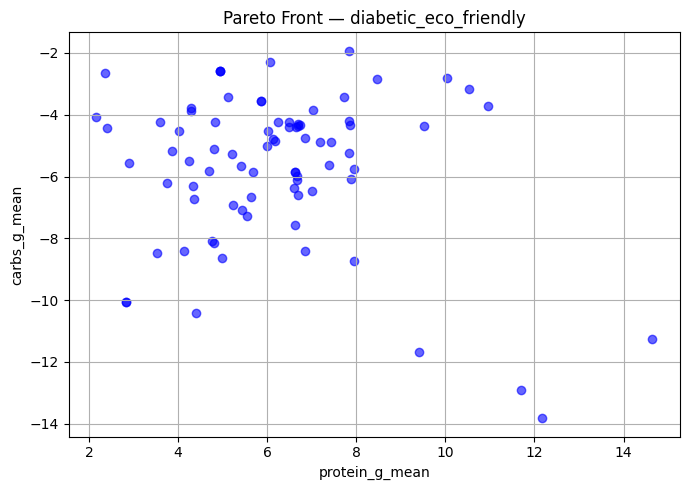

In [5]:
# =========================================================
# 📘 05_nsga2_optimizer_final_fixed.py
# Author: Apoorva Sharma
# Purpose: Personalized NSGA-II Optimization (with NaN handling & model saving)
# =========================================================

import pandas as pd
import numpy as np
import random
import json
import time
import matplotlib.pyplot as plt
from pathlib import Path
from joblib import dump
from sklearn.preprocessing import MinMaxScaler
from deap import base, creator, tools, algorithms

# ---------------------------------------------------------
# 1️⃣ Paths
# ---------------------------------------------------------
BASE_DIR = Path("D:/Complete_Data/ml_part_nutrition_project")
PROCESSED_DIR = BASE_DIR / "processed_data"
MODELS_DIR = BASE_DIR / "models"
MODELS_DIR.mkdir(parents=True, exist_ok=True)

RECIPES_PATH = PROCESSED_DIR / "recipes_final_for_optimization.csv"
OUTPUT_FILE = PROCESSED_DIR / "personalized_nsga2_results.csv"

# ---------------------------------------------------------
# 2️⃣ Load Data
# ---------------------------------------------------------
print("📥 Loading processed dataset...")
recipes = pd.read_csv(RECIPES_PATH)
print(f"✅ Loaded recipes: {recipes.shape}")
print(f"✅ Columns: {recipes.columns.tolist()}")

# Remove duplicated emission columns
recipes = recipes.loc[:, ~recipes.columns.duplicated()]

# ---------------------------------------------------------
# 3️⃣ Define User Profile (Customizable)
# ---------------------------------------------------------
USER_PROFILE = "diabetic_eco_friendly"

PROFILE_WEIGHTS = {
    "default": {
        "energy_kcal_mean": -0.3,
        "protein_g_mean": 0.4,
        "fat_g_mean": -0.2,
        "price_mean": -0.2,
        "Total_emissions_mean": -0.3,
    },
    "diabetic_eco_friendly": {
        "carbs_g_mean": -0.6,
        "protein_g_mean": 0.3,
        "price_mean": -0.2,
        "Total_emissions_mean": -0.3,
    },
    "high_protein_low_cost": {
        "protein_g_mean": 0.6,
        "price_mean": -0.4,
        "energy_kcal_mean": 0.2,
    }
}

# ---------------------------------------------------------
# 4️⃣ Select Features
# ---------------------------------------------------------
available_features = [
    c for c in recipes.columns
    if any(k in c for k in [
        "energy_kcal", "protein_g", "fat_g", "carbs_g",
        "price", "Total_emissions", "Land_use_change"
    ])
]
print(f"✅ Available numeric features: {available_features}")

# Fill NaN with mean (so scaling won't fail)
recipes[available_features] = recipes[available_features].apply(
    lambda col: col.fillna(col.mean())
)

print("🩵 Filled missing numeric values with column means.")
print(f"✅ Cleaned recipes for optimization: {recipes.shape}")

# ---------------------------------------------------------
# 5️⃣ Scale Data
# ---------------------------------------------------------
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(recipes[available_features])
dump(scaler, MODELS_DIR / "personalized_scaler.joblib")
print("✅ Scaler trained and saved.")

# ---------------------------------------------------------
# 6️⃣ NSGA-II Configuration
# ---------------------------------------------------------
weights = PROFILE_WEIGHTS.get(USER_PROFILE, PROFILE_WEIGHTS["default"])
feature_cols = [col for col in available_features if col in weights.keys()]
weights_tuple = tuple([weights[col] for col in feature_cols])

print(f"🎯 Profile: {USER_PROFILE}")
print(f"🎯 Features: {feature_cols}")
print(f"🎯 Weights: {weights_tuple}")

# DEAP setup
creator.create("FitnessMulti", base.Fitness, weights=weights_tuple)
creator.create("Individual", list, fitness=creator.FitnessMulti)
toolbox = base.Toolbox()

def evalRecipe(individual):
    vals = np.array(individual)
    return tuple(vals * np.sign(weights_tuple))

toolbox.register("attr_float", random.random)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, n=len(feature_cols))
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", evalRecipe)
toolbox.register("mate", tools.cxBlend, alpha=0.5)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=0.2, indpb=0.2)
toolbox.register("select", tools.selNSGA2)

# ---------------------------------------------------------
# 7️⃣ Run Optimization
# ---------------------------------------------------------
POP_SIZE, NGEN = 80, 30
CXPB, MUTPB = 0.7, 0.3
pop = toolbox.population(n=POP_SIZE)
hof = tools.ParetoFront()

print("\n🚀 Running Personalized NSGA-II Optimization...")
start = time.time()

algorithms.eaMuPlusLambda(
    pop, toolbox, mu=POP_SIZE, lambda_=POP_SIZE,
    cxpb=CXPB, mutpb=MUTPB, ngen=NGEN,
    stats=None, halloffame=hof, verbose=True
)

end = time.time()
print(f"✅ Optimization completed in {end - start:.2f}s")

# ---------------------------------------------------------
# 8️⃣ Save Pareto Results
# ---------------------------------------------------------
front = np.array([ind.fitness.values for ind in pop])
pareto_recipes = pd.DataFrame(front, columns=[f"score_{c}" for c in feature_cols])
pareto_recipes["recipe_index"] = np.arange(len(pareto_recipes))

pareto_results = recipes.sample(len(pareto_recipes)).reset_index(drop=True)
pareto_results = pd.concat([pareto_results, pareto_recipes], axis=1)

pareto_results.to_csv(OUTPUT_FILE, index=False)
print(f"💾 Saved Pareto-optimal recipes → {OUTPUT_FILE}")

# ---------------------------------------------------------
# 9️⃣ Save Models
# ---------------------------------------------------------
dump(pop, MODELS_DIR / f"nsga2_population_{USER_PROFILE}.joblib")
dump(front, MODELS_DIR / f"nsga2_pareto_front_{USER_PROFILE}.joblib")

config = {
    "user_profile": USER_PROFILE,
    "features_used": feature_cols,
    "population_size": POP_SIZE,
    "generations": NGEN,
    "weights": weights,
}
with open(MODELS_DIR / f"nsga2_config_{USER_PROFILE}.json", "w") as f:
    json.dump(config, f, indent=4)

print(f"💾 Model artifacts saved for '{USER_PROFILE}'")

# ---------------------------------------------------------
# 🔟 Plot Pareto Front
# ---------------------------------------------------------
if len(feature_cols) >= 2:
    plt.figure(figsize=(7, 5))
    plt.scatter(pareto_recipes[f"score_{feature_cols[0]}"],
                pareto_recipes[f"score_{feature_cols[1]}"],
                color="blue", alpha=0.6)
    plt.xlabel(feature_cols[0])
    plt.ylabel(feature_cols[1])
    plt.title(f"Pareto Front — {USER_PROFILE}")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(MODELS_DIR / f"pareto_front_{USER_PROFILE}.png", dpi=300)
    plt.show()
